# Answering Business Questions using SQL

In this guided project, we're going to practice using our SQL skills to answer business questions. In each step, we'll give you a task, and you'll need to:

- Write a SQL query to extract the relevant data
- Create plots where necessary to visualize the data
- Write a short paragraph, drawing conclusions and explaining the data and/or visualizations

Firstly, we need to import all the necessary libraries for analyzing

In [2]:
import pandas as pd
import numpy as np
import sqlite3
import matplotlib.pyplot as plt
%matplotlib inline

Now, it would be useful to create helper functions now for further usage:

In [3]:
# lets now create a function which will convert
# SQL query as a pandas dataframe:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)

In [4]:
# now we should create a function which takes
# SQL query as an argument and executes it:
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        return conn.execute(c)

In [5]:
# creating a function that calls the run_query() 
# function to return a list of all tables and views:
def show_tables():
    q = '''
    SELECT name, type
    FROM sqlite_master 
    WHERE type IN ("table", "view");
    ''' 
    return run_query(q)

# checking the show_table function:
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


Thus, currently we have 10 tables in our chinook database

## Selecting Albums to Purchase:

The Chinook record store has just signed a deal with a new record label, and you've been tasked with selecting the first three albums that will be added to the store, from a list of four.

As record label specializes in artists from USA, we should find out which genres will sell the best in the USA.

I'll need to write a query to find out which genres sell the most tracks in the USA, and then create a visualization of that data using pandas.

In [6]:
# query to find out most sold genres in US:
query = """
        WITH counting AS (
        SELECT il.* FROM invoice_line il
        INNER JOIN invoice i on il.invoice_id = i.invoice_id
        INNER JOIN customer c on i.customer_id = c.customer_id
        WHERE c.country = "USA" )
        
        
        SELECT 
                genre.name AS genre, 
                COUNT(counting.invoice_line_id) AS absolute_number, 
                CAST(COUNT(genre.name) as FLOAT) / (SELECT COUNT(*) FROM counting) as percentage
        FROM counting
        INNER JOIN track ON (track.track_id=counting.track_id)
        INNER JOIN genre ON (genre.genre_id=track.genre_id)
        GROUP BY genre.name
        ORDER BY 2 DESC
        LIMIT 10
        """

df = run_query(query)
df

,genre,absolute_number,percentage
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


Here, we identified most sold tracks in USA. Let's now visualize it using python plots.

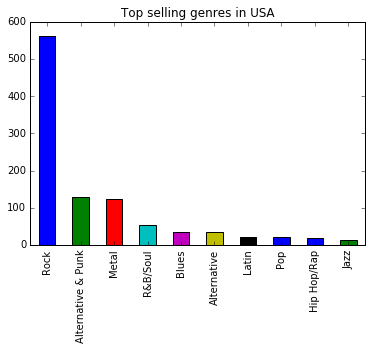

In [7]:
# creating a plot with obtained dataframe:
df.set_index("genre", inplace=True, drop=True)
df["absolute_number"].plot(kind='bar', title="Top selling genres in USA", xlim=(0, 600))
plt.xlabel(" ")
plt.show()

Based on the sales of tracks across different genres in the USA, we should purchase the new albums by the following artists:
- Red Tone (Punk)
- Slim Jim Bites (Blues)
- Meteor and the Girls (Pop)

It's worth keeping in mind that combined, these three genres only make up only 17% of total sales, so we should be on the lookout for artists and albums from the 'rock' genre, which accounts for 53% of sales.

## Analyzing Employee Sales Performance:

We have been asked to analyze the purchases of customers belonging to each employee to see if any sales support agent is performing either better or worse than the others

In [8]:
# query to indicate most effective sales support agents:

query_employee = """
SELECT 
    employee.first_name || " " ||employee.last_name as employee,
    SUM(invoice.total) as total_sold,
    employee.hire_date as started_working
FROM employee
LEFT JOIN customer ON (customer.support_rep_id=employee.employee_id)
LEFT JOIN invoice ON (invoice.customer_id=customer.customer_id)
GROUP BY 1
ORDER BY 2 DESC
LIMIT 3
"""

run_query(query_employee)

,employee,total_sold,started_working
0,Jane Peacock,1731.51,2017-04-01 00:00:00
1,Margaret Park,1584.00,2017-05-03 00:00:00
2,Steve Johnson,1393.92,2017-10-17 00:00:00


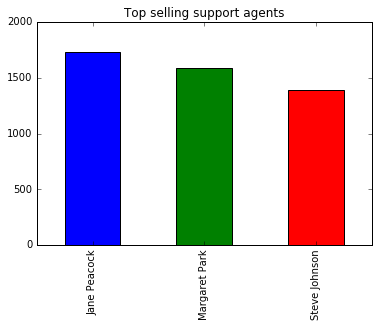

In [9]:
# creating a plot to visualize our findings:
df2 = run_query(query_employee)
df2.set_index("employee", inplace=True, drop=True)
df2["total_sold"].plot(kind='bar', title="Top selling support agents", ylim=(0, 2000))
plt.xlabel(" ")
plt.show()

While there is a 20% difference in sales between Jane (the top employee) and Steve (the bottom employee), the difference roughly corresponds with the differences in their hiring dates.

## Analyzing Sales by Country:

Our next task is to analyze the sales data for customers from each different country. In particular, you have been directed to calculate data, for each country, on the:
- total number of customers
- total value of sales
- average value of sales per customer
- average order value

In [10]:
# let's write a query which will be giving a dataframe with
# specified columns:
sales_by_country_query = """
    WITH other AS
        (SELECT
            count(distinct c.customer_id) count,
            c.country as todo,
            SUM(i.total) as total_sales,
            SUM(i.total) / COUNT(c.customer_id) as customer_average,            
            CASE 
                WHEN count(distinct c.customer_id) = 1 THEN "other"
                ELSE c.country
            END AS country
        FROM customer c
        INNER JOIN invoice i ON (i.customer_id=c.customer_id)
        GROUP BY todo
        ORDER BY 2 DESC)
        
        
    SELECT 
        country,
        count as customers_total,
        total_sales,
        customer_average
    FROM (
        SELECT other.*,
        CASE 
            WHEN other.country = "other" THEN 1
            ELSE 0
        END AS sort
        FROM other
            )
    ORDER BY sort ASC, total_sales DESC
    """

run_query(sales_by_country_query)

,country,customers_total,total_sales,customer_average
0,USA,13,1040.49,7.942672
1,Canada,8,535.59,7.047237
2,Brazil,5,427.68,7.011148
3,France,5,389.07,7.781400
4,Germany,4,334.62,8.161463
5,Czech Republic,2,273.24,9.108000
6,United Kingdom,3,245.52,8.768571
7,Portugal,2,185.13,6.383793
8,India,2,183.15,8.721429
9,other,1,114.84,8.833846


## Visualizing Sales by Country:

In [11]:
# it would be convenient to remote columns with other values
sales_by_country = run_query(sales_by_country_query)
a = sales_by_country[sales_by_country["country"] == "other"].index
country_metrics = sales_by_country.drop(a)
country_metrics

,country,customers_total,total_sales,customer_average
0,USA,13,1040.49,7.942672
1,Canada,8,535.59,7.047237
2,Brazil,5,427.68,7.011148
3,France,5,389.07,7.781400
4,Germany,4,334.62,8.161463
5,Czech Republic,2,273.24,9.108000
6,United Kingdom,3,245.52,8.768571
7,Portugal,2,185.13,6.383793
8,India,2,183.15,8.721429


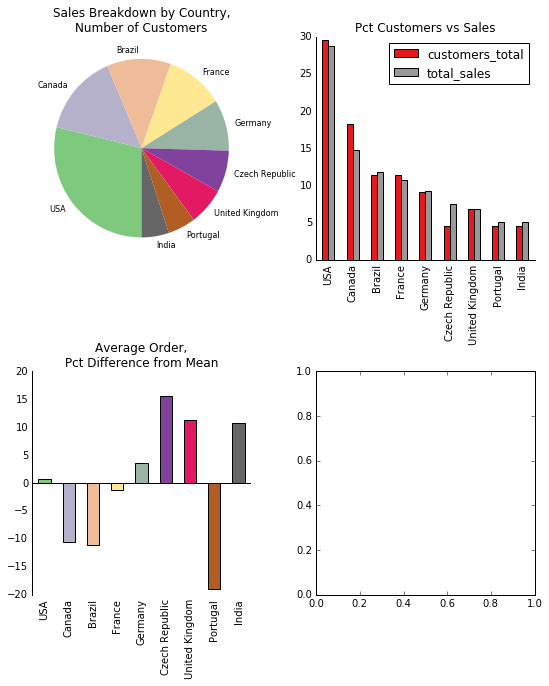

In [12]:

country_metrics.set_index("country", drop=True, inplace=True)
colors = [plt.cm.Accent(i) for i in np.linspace(0, 1, country_metrics.shape[0])]

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 10))
ax1, ax2, ax3, ax4 = axes.flatten()
fig.subplots_adjust(hspace=.5, wspace=.3)


# top left
sales_breakdown = country_metrics["total_sales"].copy().rename('')
sales_breakdown.plot.pie(
    ax=ax1,
    startangle=-90,
    counterclock=False,
    title='Sales Breakdown by Country,\nNumber of Customers',
    colormap=plt.cm.Accent,
    fontsize=8,
    wedgeprops={'linewidth':0}
    
)

# top right
cvd_cols = ["customers_total","total_sales"]
custs_vs_dollars = country_metrics[cvd_cols].copy()
custs_vs_dollars.index.name = ''
for c in cvd_cols:
    custs_vs_dollars[c] /= custs_vs_dollars[c].sum() / 100
custs_vs_dollars.plot.bar(
    ax=ax2,
    colormap=plt.cm.Set1,
    title="Pct Customers vs Sales"
)
ax2.tick_params(top="off", right="off", left="off", bottom="off")
ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)


# bottom left
avg_order = country_metrics["customer_average"].copy()
avg_order.index.name = ''
difference_from_avg = avg_order * 100 / avg_order.mean() - 100
difference_from_avg.plot.bar(
    ax=ax3,
    color=colors,
    title="Average Order,\nPct Difference from Mean"
)
ax3.tick_params(top="off", right="off", left="off", bottom="off")
ax3.axhline(0, color='k')
ax3.spines["top"].set_visible(False)
ax3.spines["right"].set_visible(False)
ax3.spines["bottom"].set_visible(False)

plt.show()

Based on the data, there may be opportunity in the following countries:
- Czech Republic
- United Kingdom
- India

It's worth keeping in mind that because the amount of data from each of these countries is relatively low. Because of this, we should be cautious spending too much money on new marketing campaigns, as the sample size is not large enough to give us high confidence. A better approach would be to run small campaigns in these countries, collecting and analyzing the new customers to make sure that these trends hold with new customers.

## Albums vs Individual Tracks:

The Chinook store is setup in a way that allows customer to make purchases in one of the two ways:
- purchase a whole album
- purchase a collection of one or more individual tracks

The store does not let customers purchase a whole album, and then add individual tracks to that same purchase (unless they do that by choosing each track manually). When customers purchase albums they are charged the same price as if they had purchased each of those tracks separately.

Management are currently considering changing their purchasing strategy to save money. The strategy they are considering is to purchase only the most popular tracks from each album from record companies, instead of purchasing every track from an album.

We have been asked to find out what percentage of purchases are individual tracks vs whole albums, so that management can use this data to understand the effect this decision might have on overall revenue.

In [13]:
albums_vs_tracks = '''
WITH invoice_first_track AS
    (
     SELECT
         il.invoice_id invoice_id,
         MIN(il.track_id) first_track_id
     FROM invoice_line il
     GROUP BY 1
    )

SELECT
    album_purchase,
    COUNT(invoice_id) number_of_invoices,
    CAST(count(invoice_id) AS FLOAT) / (
                                         SELECT COUNT(*) FROM invoice
                                      ) percent
FROM
    (
    SELECT
        ifs.*,
        CASE
            WHEN
                 (
                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 

                  EXCEPT 

                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id
                 ) IS NULL
             AND
                 (
                  SELECT il2.track_id FROM invoice_line il2
                  WHERE il2.invoice_id = ifs.invoice_id

                  EXCEPT 

                  SELECT t.track_id FROM track t
                  WHERE t.album_id = (
                                      SELECT t2.album_id FROM track t2
                                      WHERE t2.track_id = ifs.first_track_id
                                     ) 
                 ) IS NULL
             THEN "yes"
             ELSE "no"
         END AS "album_purchase"
     FROM invoice_first_track ifs
    )
GROUP BY album_purchase;
'''

run_query(albums_vs_tracks)

,album_purchase,number_of_invoices,percent
0,no,500,0.814332
1,yes,114,0.185668


Album purchases account for 18.6% of purchases. Based on this data, I would recommend against purchasing only select tracks from albums from record companies, since there is potential to lose one fifth of revenue.